## Building a Feed-Forward Neural Network

Also, one thing we may consider is divide the attributes into small sets to test which ones are best fit attributes

In [2]:
import operator
from numpy import mean, std
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, f1_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

import pickle


In [3]:
# Easy settings
DATA_FILE_NAME = "./Cancer_Data.csv"
TEST_SIZE = 0.2
KFOLD_SPLITS = 10

In [4]:
# Read data
dataset = pd.read_csv(DATA_FILE_NAME)

print("Dataset :")
print(dataset.head())
print("Diagnosis : ")
print(dataset['diagnosis'].unique())

print("Dimensions of the dataset : ", dataset.shape)
print("Features of the dataset :")
print(dataset.describe(include = 'all'))
 

Dataset :
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst

## We use k-fold Cross Validation to validate the FFNN model

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/#:~:text=The%20key%20configuration%20parameter%20for,evaluate%20models%20is%20k%3D10.

They say k = 10 is the most popular



Accuracy for batch  0  :  0.19298245614035087
Mean Square Error for batch  0  :  0.8070175438596491

Accuracy for batch  1  :  0.9298245614035088
Mean Square Error for batch  1  :  0.07017543859649122

Accuracy for batch  2  :  0.9649122807017544
Mean Square Error for batch  2  :  0.03508771929824561

Accuracy for batch  3  :  0.9473684210526315
Mean Square Error for batch  3  :  0.05263157894736842

Accuracy for batch  4  :  0.9649122807017544
Mean Square Error for batch  4  :  0.03508771929824561

Accuracy for batch  5  :  0.9824561403508771
Mean Square Error for batch  5  :  0.017543859649122806

Accuracy for batch  6  :  0.9824561403508771
Mean Square Error for batch  6  :  0.017543859649122806

Accuracy for batch  7  :  1.0
Mean Square Error for batch  7  :  0.0

Accuracy for batch  8  :  1.0
Mean Square Error for batch  8  :  0.0

Accuracy for batch  9  :  0.9107142857142857
Mean Square Error for batch  9  :  0.08928571428571429

Average Accuracy =  0.8875626566416039
Average MS

C:\Users\conta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\conta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\conta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


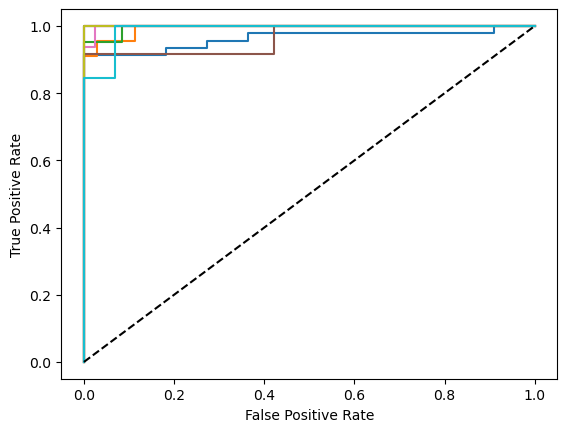

In [5]:
drop_columns = ['diagnosis', 'id', 
                'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean',
                'perimeter_se', 'area_se', 'concavity_se', 'concave points_se', 'fractal_dimension_se',
                'perimeter_worst', 'area_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst',
                ]

# Pre-process data 
X = dataset.drop(drop_columns, axis=1)
y = dataset['diagnosis']

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data = X_rescaled, columns = X.columns)

# Binarize
y = y.map({'B': 0, 'M': 1})

# step 1: randomize the dataset and create k equal size partitions
kf = KFold(n_splits=KFOLD_SPLITS)
models = []

acc = 0
mse = 0

i = 0 #keep track of batch number
# step 5: iterate k times with a different testing subset
for train_indices, test_indices in kf.split(X):
    # step 2-3: use k-1/k^th partition for the training/testing model
    start_train, stop_train = train_indices[0], train_indices[-1]+1
    start_test, stop_test = test_indices[0], test_indices[-1]+1

    X_train, X_test = X[start_train:stop_train], X[start_test:stop_test]
    y_train, y_test = y[start_train:stop_train], y[start_test:stop_test]

    # Do Neural Network
    mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.4, batch_size = 100, hidden_layer_sizes = (10, 2), max_iter = 600)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)
    details = {}
    
    train_mse = mean_squared_error(y_train, mlp.predict(X_train))
    this_mse = mean_squared_error(y_test, y_pred)
    this_acc = accuracy_score(y_test, y_pred)

    # y_test, y_pred, y_prob
    details["y_test"] = y_test
    details["y_pred"] = y_pred 
    details["y_prob"] = y_prob 
    details["Bias"] = train_mse 
    details["Variance"] = this_mse - train_mse
    
    models.append(details)

    # step 4: record the evaluating scores
    acc += accuracy_score(y_test, y_pred)
    mse += mean_squared_error(y_test, y_pred)
    print("\nAccuracy for batch ", i, " : ", this_acc)
    print("Mean Square Error for batch ", i, " : ", this_mse)
    i+=1

# step 6: find the average and select the batch with highest evaluation scores
print('\nAverage Accuracy = ', acc / KFOLD_SPLITS)
print('Average MSE = ', mse / KFOLD_SPLITS)

# Analyze models
for model in models:
    y_test = model["y_test"]
    y_pred = model["y_pred"]
    y_prob = model["y_prob"]
    bias = model["Bias"]
    variance = model["Variance"]
    
    cmat = confusion_matrix(y_test, y_pred)

    print(f"Confusion Matrix:\n {cmat}")

    # Confusion matrix whose i-th row and j-th column entry indicates the number of 
    # samples with true label being i-th class and predicted label being j-th class.

    tp = cmat[1, 1]
    tn = cmat[0, 0]
    fp = cmat[0, 1]
    fn = cmat[1, 0]

    tpr = tp / (tp + fn) # RECALL/SENSITIVITY 
    print(f"TPR: {tpr}")

    tnr = tn / (tn + fp) # SPECIFICITY
    #tnr = cmat[1][1] / (cmat[1][1] + cmat[0][1])
    print(f"TNR: {tnr}") 

    print(classification_report(y_test, y_pred))

    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob[:, 1])
    auc1 = roc_auc_score(y_test, y_prob[:, 1])

    # separate these properly later
    plt.plot(fpr1, tpr1)
    print(f"AUC1 SCORE: {auc1}")
    print(f"BIAS: {bias}")
    print(f"VAR: {variance}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.show()

In [6]:
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.4, batch_size = 100, hidden_layer_sizes = (10, 2), max_iter = 600)
mlp.fit(X, y)
pickle.dump(mlp, open("NN-Model", 'wb'))